In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import glob
from matplotlib import gridspec


try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model


TensorFlow 2.x selected.
2.1.0


In [0]:
def import_data(dr = None, condition = None):
    all_files = glob.glob(rootdr + condition)

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=0, header=0)
        li.append(df)

    data_raw = pd.concat(li, axis=0, ignore_index=True)

    data = data_raw.copy()

    data = data.ix[data['evol_stage'] >= 1]

    log_column = ['star_age','effective_T','luminosity']
    data[log_column] = np.log10(data[log_column])
    #data.tail()
    return data


In [0]:
def prepare_data_for_one_mode(data = None, mode_column_name = None):
    data_new = data.copy()
    data_new[mode_column_name] = np.log10(data_new[mode_column_name])
    data_new = data_new.replace([np.inf, -np.inf], np.nan)
    data_new.isna().sum()
    data_new = data_new.dropna()
    data_new = data_new.sample(frac = 1.0, random_state=1)
    return data_new

In [0]:
def prepare_train_set(data = None, inputs = None, outputs = None):
    train_dataset = data[inputs]
    train_labels = data[outputs]
    return train_dataset, train_labels

In [0]:
def plot_history(history, savefig = None):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('log(Mean Abs Error [MPG])')
    plt.plot(hist['epoch'], np.log10(hist['mae']),
             label='Train Error')
    plt.plot(hist['epoch'], np.log10(hist['val_mae']),
             label = 'Val Error')
    #plt.ylim([-8,-1])
    plt.legend()
    plt.savefig(savefig + '.png')
    plt.close()
    print('figure is saved in' + savefig)
    return  
    

In [0]:
def tf_model_one_mode(mode_name = None, train_dataset = None, train_labels = None, epochs = None, savemodel = None):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation ='elu', input_shape=[len(train_dataset.keys())],kernel_regularizer=regularizers.l2(0.000001)))
    model.add(layers.Dense(128, activation ='elu',kernel_regularizer=regularizers.l2(0.000001)))
    model.add(layers.Dense(128, activation ='elu',kernel_regularizer=regularizers.l2(0.000001)))
    model.add(layers.Dense(128, activation ='elu',kernel_regularizer=regularizers.l2(0.000001)))
    model.add(layers.Dense(128, activation ='elu',kernel_regularizer=regularizers.l2(0.000001)))
    model.add(layers.Dense(128, activation ='elu',kernel_regularizer=regularizers.l2(0.000001)))
    model.add(layers.Dense(1, activation ='linear'))

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    #optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9995, beta_2=0.9999)
          
    model.compile(loss='mae',optimizer=optimizer,metrics=['mae', 'mse'])
#Use the .summary method to print a simple description of the model
#train model

# Display training progress by printing a single dot for each completed epoch
    class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

    #EPOCHS = 1000
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.000001, patience = 0.3*epochs)

    EPOCHS = epochs

    history = model.fit(train_dataset, train_labels, epochs=EPOCHS, 
                        batch_size= int(0.6*len(train_dataset)),
                        validation_split = 0.4, verbose=0, callbacks=[early_stop,])# PrintDot()])#callbacks = [PrintDot()])

    model.save(savemodel)
    
    plot_history(history, savefig = savemodel)
    
    loss, mae, mse = model.evaluate(train_dataset, train_labels, verbose=2)
    print("Testing set Mean Abs Error for" + mode_name +": {:5.2f}".format(mae))
    
    return model

In [0]:
def plot_mode_predictions(model = None,mode_column_name=None, train_dataset = None, train_labels = None, savefig = None):
    print(model.summary())
    loss, mae, mse = model.evaluate(train_dataset, train_labels, verbose=2)
    predictions = model.predict(train_dataset)
    
    error_nu = 10**predictions[:,0] - 10**train_labels[mode_column_name].values
    
    plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(1, 2) #, width_ratios=[2, 1]) #,height_ratios=[2,1])
    p0 = plt.subplot(gs[0,0])
    p0.axis([4.5, 3.5, 3.0, -0.5 ])
    plt.xlabel(r'$T_{\rm eff}$ (K)')
    plt.ylabel(r'($\nu$ ($\mu$Hz)')
    p0.scatter(train_dataset['effective_T'], train_labels[mode_column_name], marker='.',color = 'k') #, facecolors='none', edgecolors='k')    
    p0.scatter(train_dataset['effective_T'].values, predictions[:,0], marker='.',color = 'r') #, facecolors='none', edgecolors='k')
    
    p1 = plt.subplot(gs[0,1])
    p1.hist(error_nu, bins = 200,range = [-0.02,0.02])
    plt.xlabel("Prediction Error [nu_0_1] (microHz)")
    plt.ylabel("Count")       
    plt.savefig(savefig)
    print('Fig saved in' + savefig)
    return predictions

In [8]:
!ls '/Users/litz/Documents/GitHub/data/'
rootdr = '/Users/litz/Documents/GitHub/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
20191122nn_hrd_t2-all-sg-track.ipynb
20191125square_nn_hrd_t2-all-sg-track_version1.ipynb
20191201nn_hrd_t3-radial-modes.ipynb
20200115nn_hrd_test_grid3.ipynb
20200115nn_hrd_test_ov.ipynb
20200127nn_hrd-radial-modes.ipynb
20200127_nu_0_1.png
20200127_train_prediction_nu_0_1.png
20200127_validation.png
20200127_validation_prediction_nu_0_1.png
20200129nn_hrd_radial_modes_grid2.ipynb
dnu_dpi_test.png
grid2_subset
histrory_20191201.png
hrd_dataset.png
hrd_testdat

In [10]:
data = import_data(dr = rootdr, condition = 'grid2_subset/simple_grid_v3_s1/*.csv')
data.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


,model_number,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,initial_fov,star_mass,star_age,ms_lifetime,frac_age,effective_T,luminosity,radius,log_g,surface_h1,surface_he4,surface_Z,star_feh,center_h1,center_he4,log_center_T,log_center_Rho,he_core_mass,delta_nu,delta_Pg,nu_max,acoustic_cutoff,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,nu_0_8,nu_0_9,nu_0_10,nu_0_11,nu_0_12,nu_0_13,nu_0_14,nu_0_15,nu_0_16,nu_0_17,nu_0_18,nu_0_19,nu_0_20,nu_0_21,nu_0_22,nu_0_23,nu_0_24,nu_0_25,nu_0_26,nu_0_27,nu_0_28,nu_0_29,nu_0_30,nu_0_31,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,delta_nu_fit
202920,1844,2,1.2,0.32,0.2,1.7,0,1.170117,0.699427,3.461771,1.445867,3.585951,2.291085,31.397752,1.512322,0.644305,0.335883,0.019085,0.213922,0.0,0.981347,7.669952,5.494140,0.305147,0.918737,48.240662,4.504737,6.782404,1.359332,2.237130,2.926075,3.728707,4.502244,5.360049,6.195375,7.024111,7.739001,8.284752,9.000740,9.828667,10.666300,11.475471,12.226591,12.956046,13.736105,14.561019,15.403499,16.234515,17.037168,17.804513,18.574044,19.375566,20.205051,21.042018,21.867152,22.666468,23.444539,24.229435,25.039995,25.869958,26.703219,27.524587,28.322541,29.105769,29.899156,30.714326,31.544695,32.376086,0.811680
202921,1845,2,1.2,0.32,0.2,1.7,0,1.169989,0.699433,3.461771,1.445889,3.585567,2.295815,31.625107,1.506007,0.644305,0.335883,0.019085,0.213922,0.0,0.981347,7.670329,5.494884,0.305369,0.909154,48.172726,4.441679,6.686287,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
202922,1846,2,1.2,0.32,0.2,1.7,0,1.169875,0.699439,3.461771,1.445908,3.585497,2.296664,31.666326,1.504834,0.644305,0.335883,0.019085,0.213922,0.0,0.981347,7.670682,5.495572,0.305579,0.907428,48.147067,4.430053,6.668570,1.341860,2.206786,2.885530,3.678486,4.444595,5.290170,6.116390,6.932292,7.630606,8.168838,8.883751,9.703392,10.529590,11.325887,12.064259,12.785240,13.559100,14.375364,15.207362,16.026229,16.815646,17.571434,18.332884,19.127146,19.947672,20.773629,21.586155,22.372374,23.139514,23.916720,24.719624,25.540330,26.362364,27.170539,27.955487,28.728180,29.514304,30.322059,31.142578,31.962511,0.801347
202923,1847,2,1.2,0.32,0.2,1.7,0,1.169770,0.699444,3.461771,1.445926,3.585420,2.297646,31.713364,1.503505,0.644305,0.335883,0.019085,0.213922,0.0,0.981347,7.671016,5.496222,0.305781,0.905467,48.121275,4.416911,6.648564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
202924,1848,2,1.2,0.32,0.2,1.7,0,1.169642,0.699451,3.461771,1.445947,3.585041,2.302322,31.940245,1.497266,0.644305,0.335883,0.019085,0.213922,0.0,0.981347,7.671389,5.496956,0.306000,0.896137,48.054381,4.355810,6.555445,1.324408,2.176503,2.845151,3.628377,4.387119,5.220451,6.037566,6.840554,7.522156,8.053760,8.767204,9.578374,10.393088,11.176439,11.902231,12.615077,13.382641,14.190172,15.011533,15.818210,16.594326,17.338916,18.092491,18.879470,19.690827,20.505674,21.305422,22.078666,22.835258,23.604976,24.400149,25.211366,26.021992,26.816795,27.588896,28.351705,29.130637,29.930802,30.741262,31.549330,0.791052


In [0]:
mode_n_orders = np.arange(1,41)
mode_column_names = [f'nu_0_{i}' for i in mode_n_orders]
mode_column_names = ['nu_0_1']

In [0]:
for mode_column_name in mode_column_names:

    data_new = prepare_data_for_one_mode(data = data, mode_column_name = mode_column_name)

    print(len(data_new['model_number']))

    inputs = ['initial_mass','initial_Yinit','initial_feh','initial_MLT','initial_fov',
          'star_mass','star_age','effective_T','log_g','luminosity']
    outputs = [mode_column_name]
    train_dataset, train_labels = prepare_train_set(data = data_new, inputs = inputs, outputs = outputs)

    print("tf is training for " + mode_column_name)

    model = tf_model_one_mode(mode_name = mode_column_name, 
                              train_dataset = train_dataset, 
                              train_labels = train_labels, 
                              epochs = 100000, 
                              savemodel = rootdr + "grid_2_NN" + mode_column_name + ".h5")
    
    predictions = plot_mode_predictions(model = model, 
                                        mode_column_name = mode_column_name,
                                        train_dataset = train_dataset, 
                                        train_labels = train_labels,  
                                        savefig = rootdr + mode_column_name + 'on_grid.png')
    

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


51520
tf is training for nu_0_1


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

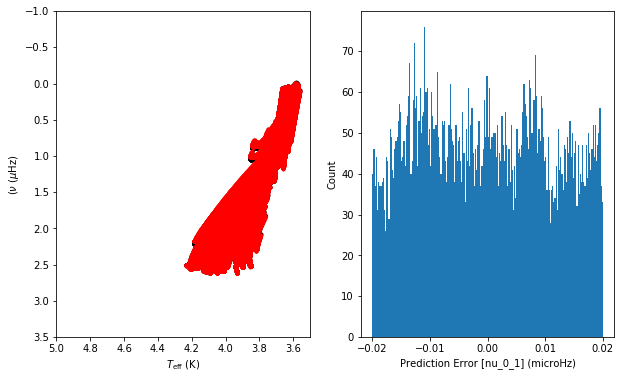

In [15]:
#load model and prediction again
model_x =  load_model(rootdr + "grid_2_NN" + mode_column_name + ".h5")
predictions = plot_mode_predictions(model = model_x, 
                                    mode_column_name = mode_column_name,
                                    train_dataset = train_dataset, 
                                    train_labels = train_labels,  
                                    savefig = rootdr + mode_column_name + 'on_grid_x.png')